In [33]:
import sys
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [34]:
from coco.job import Job

In [35]:
current_job = Job.from_name("nyu_depth")

state_run
phase_train
1


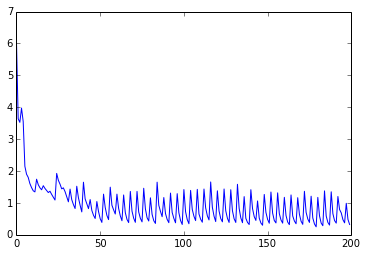

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Refresh job
current_job.load()
data = current_job.data

train_losses = np.array(data["train_losses"]).squeeze()


print data["state"]
print data["phase"]
print data["epoch"]

plt.plot(train_losses[:])
plt.show()

if "val_losses" in data:
    val_losses = np.array(data["val_losses"]).squeeze()
    plt.plot(val_losses)
    plt.show()

    w = 40
    l = []
    for i in range(0,len(val_losses),w):
        l.append((val_losses[i:i+w].mean()))

    plt.plot(l)
    plt.show()

from coco.database_reader import HDF5DatabaseReader
from coco.multiprocess import MultiProcessor
from coco.transformations import zoom_rotate, random_rgb, random_crop, normalize_images, downsample, clip, noise, exp


train_db = "/data/data/nyu_v2.hdf5"
val_db = "/data/data/test_v2.hdf5"

global mean
mean = np.load("/data/data/nyu_v2.npy")

def process_train(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]

    size = (228, 304)
    
    global mean
    images, labels = exp(images, labels)
    images, labels = zoom_rotate(images, labels)
    images, labels = random_rgb(images, labels)
    images, labels = noise(images, labels)
    images, labels = clip(images, labels, ic=(0. ,255.))
    
    # images, labels = normalize_images(images, labels, mean, std=71.571201304890508)
    
    images, labels = random_crop(images, labels, size)
    images, labels = downsample(images, labels, (1, 2))

    return images, labels


def process_val(images, labels):
    images = images.astype(np.float32)
    labels = labels.astype(np.float32)

    assert images.shape[0] == labels.shape[0]
    global mean

    size = (228, 304)
    # images, labels = normalize_images(images, labels, mean, std=71.571201304890508)
    images, labels = random_crop(images, labels, size, deterministic=True)
    images, labels = downsample(images, labels, (1, 2))

    return images, labels

batch_size = 16

train_reader = HDF5DatabaseReader(label_key="depths")
train_reader.setup_read(train_db)

val_reader = HDF5DatabaseReader(label_key="depths")
val_reader.setup_read(val_db)

train_processor = MultiProcessor(
    train_reader, func=process_train, batch_size=batch_size)
val_processor = MultiProcessor(
    val_reader, func=process_val, batch_size=batch_size)

train_processor.start_daemons()

d = 0
for batch in train_processor.iterate():
    i,de = batch
    d += 1
    if d < 5:
        plt.imshow(i[6].transpose((1,2,0)).astype(np.uint8))
        plt.show()
        plt.imshow(de[6])
        plt.show()
        break